# Script de Geração de Perguntas para miniOntoGeoLogicaInstanciasRelacoes.rdf

Gerar perguntas a partir do Grafo de Conhecimento (PetroKGraph) e criar o contexto relevante para cada pergunta.

To begin, we need to import the necessary modules and set up the environment variables.

### Requirements

```bash
!pip install networkx 
!pip install node2vec 
!pip install rdflib

!pip install openai
!pip install langchain
!pip install neo4j
!pip install transformers
```

In [79]:
import os
import json
import rdflib
import networkx as nx
from node2vec import Node2Vec

### **✅ Carregar o PetroKGraph**

In [80]:
from rdflib import Graph, URIRef, Namespace, Literal

g = rdflib.Graph()
g.parse("C:\Projetos GIT\LangChain\Data\miniKGraph\miniOntoGeoLogicaInstanciasRelacoes.rdf", format="xml") 

G = nx.Graph()

# Añadir nodos y aristas del grafo RDF al grafo de NetworkX
for subj, pred, obj in g:
   
    G.add_edge(str(subj), str(obj), label=str(pred))

In [81]:
print(f"* * * * * * * * *")
# Numero de nodos, ejes del grafo y grado medio
nodos = G.number_of_nodes()
ejes = G.number_of_edges()
k = ejes*2/nodos
densidad = nx.density(G)
print(f"Grafo con {nodos} nodos, {ejes} ejes, densidad {densidad} y grado medio {k}")

# Grado de los nodos: el número de conexiones de cada nodo
nx.degree(G)

* * * * * * * * *
Grafo con 4472 nodos, 11915 ejes, densidad 0.0011918389589999395 y grado medio 5.32871198568873


DegreeView({'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678': 15, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_141': 91, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Bartonian_quality': 11, 'Idade Bartoniana': 4, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Stenian': 5, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#geological_time_interval': 352, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Serravallian_quality': 9, 'Mesomioceno': 4, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022740': 6, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#BASE_CD_BACIA_030': 249, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito_formacao_006': 4, 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito': 7

In [82]:
# Imprimir nodos
print("Nodos del grafo:")
print(G.nodes())

Nodos del grafo:
['http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_141', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Bartonian_quality', 'Idade Bartoniana', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Stenian', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#geological_time_interval', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Serravallian_quality', 'Mesomioceno', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022740', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#BASE_CD_BACIA_030', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito_formacao_006', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito', 'http://www.semanticweb.org/bg40/on

In [83]:
print("\nAristas del grafo con etiquetas:")
for edge in G.edges(data=True):
    print(edge)


Aristas del grafo con etiquetas:
('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_141', {'label': 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#crosses'})
('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_246', {'label': 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#crosses'})
('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', '2-TNST-1-AM', {'label': 'http://www.w3.org/2000/01/rdf-schema#label'})
('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', 'http://www.w3.org/2002/07/owl#NamedIndividual', {'label': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'})
('http://www.semanticweb.org/bg40/ontologies/2022/5

### ✅ Verificar etiquetas del Grafo

In [84]:
def verificar_etiquetas(grafo):
  """
  Recorre el grafo y verifica si cada nodo tiene una etiqueta asociada.
  """
  nodos_sin_etiqueta = []
  for nodo in grafo.nodes:
    if not grafo.has_node(nodo):
      continue

    etiqueta = grafo.nodes[nodo].get("label", None)
    if not etiqueta:
      nodos_sin_etiqueta.append(nodo)

  return nodos_sin_etiqueta

grafo = G

nodos_sin_etiqueta = verificar_etiquetas(grafo)
if nodos_sin_etiqueta:
  print(f"Se encontraron {len(nodos_sin_etiqueta)} nodos sin etiqueta:")
  print(nodos_sin_etiqueta)
else:
  print("Todos los nodos tienen etiqueta.")

Se encontraron 4472 nodos sin etiqueta:
['http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_141', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Bartonian_quality', 'Idade Bartoniana', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Stenian', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#geological_time_interval', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Serravallian_quality', 'Mesomioceno', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022740', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#BASE_CD_BACIA_030', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito_formacao_006', 'http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#metassiltito', 'http://www.

In [85]:
def verificar_etiquetas_con_etiqueta(grafo):
  """
  Recorre el grafo y verifica si cada nodo tiene una etiqueta asociada.
  Si un nodo tiene etiqueta, imprime el nodo y su etiqueta.
  """
  nodos_sin_etiqueta = verificar_etiquetas(grafo)
  if nodos_sin_etiqueta:
    print(f"Se encontraron {len(nodos_sin_etiqueta)} nodos sin etiqueta:")
    for nodo in nodos_sin_etiqueta:
      etiqueta = grafo.nodes[nodo].get("label", None)
      if etiqueta:
        print(f"- {nodo}: {etiqueta}")
  else:
    print("Todos los nodos tienen etiqueta.")

# Ejemplo de uso
grafo = G
# Agregue nodos al grafo...

verificar_etiquetas_con_etiqueta(grafo)


Se encontraron 4472 nodos sin etiqueta:


### ✅ **Inspección de las Triplas**


Primero, inspeccionar las triplas para ver cuántos elementos contienen. al parecer las "triples" encontrados tienen una cantidad significativamente mayor de elementos de lo esperado, esto va en concordancia a lo estudiado del grafo, lo que indica que están representando algo más complejo, siendo que son descripciones más detalladas de entidades.

In [86]:
# Inspeccionar las triplas
for triple in G:
    print(triple)
    print(f"Number of elements in triple: {len(triple)}")
    if len(triple) <= 3:
        print("Found a non-triple element")


http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022678
Number of elements in triple: 89
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#formacao_141
Number of elements in triple: 82
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Bartonian_quality
Number of elements in triple: 87
Idade Bartoniana
Number of elements in triple: 16
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Stenian
Number of elements in triple: 77
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#geological_time_interval
Number of elements in triple: 94
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#Serravallian_quality
Number of elements in triple: 90
Mesomioceno
Number of elements in triple: 11
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#POCO_CD_POCO_022740
Number of elements in triple: 89
http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-

Las "triplas" encontradas contienen descripciones más detalladas de entidades, descartar estos elementos resultaría en la pérdida de datos, entonces se adaptará el código para manejar este caso adecuadamente. Una forma de abordar esto es manejar triplas con un número variable de elementos. En lugar de asumir que cada triple tiene exactamente tres elementos.

### ✅ **Consultar o PetroKGraph atualizado para obter informação relevante**

In [87]:
from rdflib import Graph, URIRef, Namespace, Literal

fields = {}
basins = {}
wells  = {}
formations = {}
for s, p, o in g:
    if isinstance(s, URIRef) and "CAMP_CD_CAMPO" in s:
        campo_id = s.split("#")[1]
        if campo_id not in fields:
            fields[campo_id] = {"types": [], "located_in": [], "labels": [], "related": []}
        if "type" in p:
            fields[campo_id]["types"].append(o)
        elif "located_in" in p:
            fields[campo_id]["located_in"].append(o)
        elif "label" in p:
            fields[campo_id]["labels"].append(str(o))
        else:
            fields[campo_id]["related"].append((p, o))

    if isinstance(s, URIRef) and "BASE_CD_BACIA" in s:
        bacia_id = s.split("#")[1]
        if bacia_id not in basins:
            basins[bacia_id] = {"types": [], "labels": []}
        if "type" in p:
            basins[bacia_id]["types"].append(o)
        elif "label" in p:
            basins[bacia_id]["labels"].append(str(o))
            
    if isinstance(s, URIRef) and "POCO_CD_POCO" in s:
        poco_id = s.split("#")[1]
        if poco_id not in wells:
            wells[poco_id] = {"types": [], "located_in": [], "labels": [], "crosses": []}
        if "type" in p:
            wells[poco_id]["types"].append(o)
        elif "located_in" in p:
            wells[poco_id]["located_in"].append(o)
        elif "crosses" in p:
            wells[poco_id]["crosses"].append(str(o))
        elif "label" in p:
            wells[poco_id]["labels"].append(str(o))

    if isinstance(s, URIRef) and "formacao" in s:
        unidade_lito_id = s.split("#")[1]
        if unidade_lito_id not in formations:
            formations[unidade_lito_id] = {"types": [], "located_in": [], "has_age": [], "part_of": [],"carrier_of": [], "constituted_by": [], "crosses": [],  "labels": []}
        if "type" in p:
            formations[unidade_lito_id]["types"].append(o)
        elif "located_in" in p:
            formations[unidade_lito_id]["located_in"].append(str(o))  
        elif "constituted_by" in p:
            formations[unidade_lito_id]["constituted_by"].append(o) 
        elif "has_age" in p:
            formations[unidade_lito_id]["has_age"].append(str(o))  
        elif "part_of" in p:
            formations[unidade_lito_id]["part_of"].append(o)   
        elif "carrier_of" in p:
            formations[unidade_lito_id]["carrier_of"].append(o) 
        elif "crosses" in p:
            formations[unidade_lito_id]["crosses"].append(str(o))
        elif "label" in p:
            formations[unidade_lito_id]["labels"].append(str(o))
          

    if isinstance(s, URIRef) and "grupo" in s:
        unidade_lito_id = s.split("#")[1]
        if unidade_lito_id not in formations:
            formations[unidade_lito_id] = {"types": [], "located_in": [], "has_age": [], "part_of": [],"carrier_of": [], "constituted_by": [], "crosses": [],  "labels": []}
        if "type" in p:
            formations[unidade_lito_id]["types"].append(o)
        elif "located_in" in p:
            formations[unidade_lito_id]["located_in"].append(str(o))  
        elif "constituted_by" in p:
            formations[unidade_lito_id]["constituted_by"].append(o) 
        elif "has_age" in p:
            formations[unidade_lito_id]["has_age"].append(str(o))  
        elif "part_of" in p:
            formations[unidade_lito_id]["part_of"].append(o)  
        elif "carrier_of" in p:
            formations[unidade_lito_id]["carrier_of"].append(o)  
        elif "crosses" in p:
            formations[unidade_lito_id]["crosses"].append(str(o))
        elif "label" in p:
            formations[unidade_lito_id]["labels"].append(str(o))
          

    if isinstance(s, URIRef) and "membro" in s:
        unidade_lito_id = s.split("#")[1]
        if unidade_lito_id not in formations:
            formations[unidade_lito_id] = {"types": [], "located_in": [], "has_age": [], "part_of": [],"carrier_of": [], "constituted_by": [], "crosses": [],  "labels": [] }
        if "type" in p:
            formations[unidade_lito_id]["types"].append(o)
        elif "located_in" in p:
            formations[unidade_lito_id]["located_in"].append(str(o))  
        elif "constituted_by" in p:
            formations[unidade_lito_id]["constituted_by"].append(o) 
        elif "has_age" in p:
            formations[unidade_lito_id]["has_age"].append(str(o))  
        elif "part_of" in p:
            formations[unidade_lito_id]["part_of"].append(o)   
        elif "carrier_of" in p:
            formations[unidade_lito_id]["carrier_of"].append(o) 
        elif "crosses" in p:
            formations[unidade_lito_id]["crosses"].append(str(o))
        elif "label" in p:
            formations[unidade_lito_id]["labels"].append(str(o))
          

In [88]:
print("Basins:", basins.keys())

print("Fields:", fields.keys())

print("Wells:", wells.keys())

Basins: dict_keys(['BASE_CD_BACIA_266', 'BASE_CD_BACIA_030'])
Fields: dict_keys(['CAMP_CD_CAMPO_0572', 'CAMP_CD_CAMPO_0721', 'CAMP_CD_CAMPO_0109', 'CAMP_CD_CAMPO_0888', 'CAMP_CD_CAMPO_0131', 'CAMP_CD_CAMPO_0633', 'CAMP_CD_CAMPO_0890', 'CAMP_CD_CAMPO_0108'])
Wells: dict_keys(['POCO_CD_POCO_022678', 'POCO_CD_POCO_022740', 'POCO_CD_POCO_006377', 'POCO_CD_POCO_022450', 'POCO_CD_POCO_005749', 'POCO_CD_POCO_005663', 'POCO_CD_POCO_023071', 'POCO_CD_POCO_005781', 'POCO_CD_POCO_023088', 'POCO_CD_POCO_022783', 'POCO_CD_POCO_022806', 'POCO_CD_POCO_022822', 'POCO_CD_POCO_005757', 'POCO_CD_POCO_000005', 'POCO_CD_POCO_022775', 'POCO_CD_POCO_022877', 'POCO_CD_POCO_022866', 'POCO_CD_POCO_023241', 'POCO_CD_POCO_006215', 'POCO_CD_POCO_022706', 'POCO_CD_POCO_022709', 'POCO_CD_POCO_022556', 'POCO_CD_POCO_000003', 'POCO_CD_POCO_005657', 'POCO_CD_POCO_022768', 'POCO_CD_POCO_023014', 'POCO_CD_POCO_022704', 'POCO_CD_POCO_022675', 'POCO_CD_POCO_022782', 'POCO_CD_POCO_022845', 'POCO_CD_POCO_022885', 'POCO_CD_PO

####  ✅ **Corroborar informação extraida**

In [90]:
# Formações extraídos
for forma, info in formations.items():
        print(f"** Unidade Litoestretigrafica: {forma}")
        print(f"  Parte de: {info['part_of']}")
        print(f"  Constituted  by: {info['constituted_by']}")
        print(f"  Crosses  by: {info['crosses']}")
        print(f"  Label: {info['labels']}")
        print(f"  Tem idade: {info['has_age']}")
        print(f"  Portadora de: {info['carrier_of']}")

** Unidade Litoestretigrafica: metassiltito_formacao_006
  Parte de: []
  Constituted  by: []
  Crosses  by: []
  Label: ['metassiltito']
  Tem idade: []
  Portadora de: []
** Unidade Litoestretigrafica: Visean_quality_formacao_064
  Parte de: []
  Constituted  by: []
  Crosses  by: []
  Label: ['Idade Viseana', 'Viseano', 'Andar Viseano']
  Tem idade: []
  Portadora de: []
** Unidade Litoestretigrafica: formacao_204
  Parte de: [rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#grupo_011')]
  Constituted  by: [rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#siltstone_formacao_204'), rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#dolomite_formacao_204'), rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#calciarenite_formacao_204'), rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#mud

In [91]:
# Función para obtener el nombre de un bacia
def obtener_nombre_bacia(uri):
    bacia_id = uri.split("#")[1]
    if bacia_id in basins:
        return basins[bacia_id]["labels"]
    return [str(uri)]

# Campos extraídos
for campo, info in fields.items():
        print(f"** ** ** **")
        print(f"  Campo: {campo}")
        print(f"  Nombres: {info['labels']}")
        localizacion = info['located_in']
        nombres_bacia = [obtener_nombre_bacia(uri) for uri in localizacion]
        print(f"  Localizado na bacia: {nombres_bacia}")

** ** ** **
  Campo: CAMP_CD_CAMPO_0572
  Nombres: ['JIRIBATUBA']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']]
** ** ** **
  Campo: CAMP_CD_CAMPO_0721
  Nombres: ['MORRO DO BARRO']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']]
** ** ** **
  Campo: CAMP_CD_CAMPO_0109
  Nombres: ['ÁREA DO B097', 'SARDINHA']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']]
** ** ** **
  Campo: CAMP_CD_CAMPO_0888
  Nombres: ['MANATI', 'ÁREA DO B128']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']]
** ** ** **
  Campo: CAMP_CD_CAMPO_0131
  Nombres: ['RIO UATUMA', 'AZULÃO', 'AZULAO']
  Localizado na bacia: [['BACIA DE AMAZONAS', 'AMAZONAS']]
** ** ** **
  Campo: CAMP_CD_CAMPO_0633
  Nom

In [92]:
# Bacias extraídas
for basin, info in basins.items():
        print(f"** ** ** **")
        print(f"  Bacia: {basin}")
        print(f"  Nombres: {info['labels']}")

** ** ** **
  Bacia: BASE_CD_BACIA_266
  Nombres: ['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']
** ** ** **
  Bacia: BASE_CD_BACIA_030
  Nombres: ['BACIA DE AMAZONAS', 'AMAZONAS']


In [93]:
print(basins )

{'BASE_CD_BACIA_266': {'types': [rdflib.term.URIRef('http://www.w3.org/2002/07/owl#NamedIndividual'), rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#basin')], 'labels': ['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']}, 'BASE_CD_BACIA_030': {'types': [rdflib.term.URIRef('http://www.w3.org/2002/07/owl#NamedIndividual'), rdflib.term.URIRef('http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#basin')], 'labels': ['BACIA DE AMAZONAS', 'AMAZONAS']}}


In [94]:
# Poços extraídos
counter = 0
for well, info in wells.items():
    counter += 1
    print(f"Poço: {well}")
    #print(f"  Tipos: {info['types']}")
    print(f"  Nombre del poço: {info['labels']}")
    localizacion = info['located_in']
    nombres_bacia = [obtener_nombre_bacia(uri) for uri in localizacion]
    print(f"  Localizado na bacia: {nombres_bacia}")

# Poços extraídos
print(f"Total de poços: {counter}")

Poço: POCO_CD_POCO_022678
  Nombre del poço: ['2-TNST-1-AM']
  Localizado na bacia: [['BACIA DE AMAZONAS', 'AMAZONAS']]
Poço: POCO_CD_POCO_022740
  Nombre del poço: ['1-AR-1-AM']
  Localizado na bacia: [['BACIA DE AMAZONAS', 'AMAZONAS']]
Poço: POCO_CD_POCO_006377
  Nombre del poço: ['3-MNT-8DP-BAS', '3-BRSA-599DP-BAS']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR'], ['http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#CAMP_CD_CAMPO_0888']]
Poço: POCO_CD_POCO_022450
  Nombre del poço: ['1-ICA-1-AM']
  Localizado na bacia: [['BACIA DE AMAZONAS', 'AMAZONAS']]
Poço: POCO_CD_POCO_005749
  Nombre del poço: ['2-NBST-1D-BA']
  Localizado na bacia: [['ALMADA TERRA', 'CAMAMU-ALMADA', 'CAMAMU TERRA', 'ALMADA MAR', 'BACIA DE CAMAMU-ALMADA', 'CAMAMU MAR']]
Poço: POCO_CD_POCO_005663
  Nombre del poço: ['3-MB-5-BA']
  Localizado na bacia: [['http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-on

####  ✅  **Visualização do grafo**

Usando [WebVOWL](https://service.tib.eu/webvowl/) pode ser possivel visualizar cada nó no grafo.

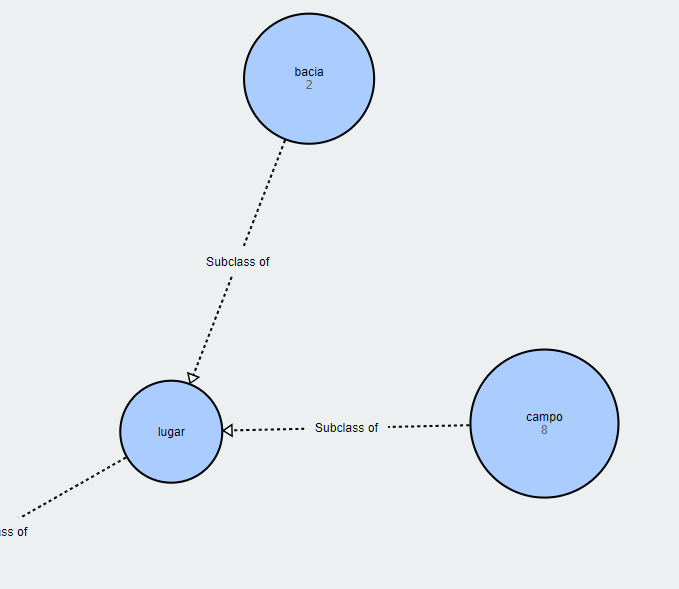

### 🔎 **Gerar as perguntas baseado no miniKGraph** 

In [120]:
namespace_base = rdflib.Namespace("http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#")
rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
rdf= Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
import uuid

def gerar_perguntas(g):
    questions = []
    id_counter = 0  # Contador para los IDs de las preguntas
                
# ******** PERGUNTAS SOBRES OS NOMES RELACIONADOS NOS LABELS ******** 

    for bacia_URI, info in basins.items():
        
        if info["labels"]:
            basins_names = []
            
            for bacia_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{bacia_URI}"), rdfs.label):
                bas = str(bacia_name).title()
                basins_names.append(str(bas))
                
            if basins_names:
                all_names_basin = ", ".join(basins_names)
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Qual é o nome da bacia {bacia_URI}?",
                    "answer": basins_names,
                    "context": f"O nome da bacia {bacia_URI} é {all_names_basin}."
                })  

    for campo, info in fields.items():
        if info["labels"]:
            fields_names = []

            for campo_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{campo}"), rdfs.label):
                camp = str(campo_name).title()
                fields_names.append(str(camp))

            if fields_names:
                all_fields_names = ", ".join(fields_names)
                id_counter += 1

                questions.append({
                    "id": id_counter,
                    "question": f"Qual é o nome do campo {campo}?",
                    "answer": fields_names,
                    "context": f"O nome do campo {campo} é {all_fields_names}."
                })

    for formacoes, info in formations.items():
        if info["labels"]:
            all_names = []

            for formacao_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{formacoes}"), rdfs.label):
                all_names.append(str(formacao_name))

            if formacoes.startswith('formacao'):
                all_names_ = ", ".join(all_names)
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Qual é o nome da {formacoes}?", # nome da formação 
                    "answer": all_names,
                    "context": f"O nome da formação {formacoes} é {all_names_}."
                })  
                
# ******** ******** ******** ******** ******** ******** ******** 
  
    for campo, info in fields.items():
        if info["located_in"]:
            location = info["located_in"][0].split("#")[1]
            campoID= campo
            
            campo_name = info["labels"][0] if info["labels"] else campo
            location_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{location}"), rdfs.label).title()

            all_campo_names = []
            for campo_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{campo}"), rdfs.label):
                all_campo_names.append(str(campo_name))
            

            if all_campo_names:
                all_names = ", ".join(all_campo_names)
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Em que BACIA está localizado o CAMPO {campo_name}?",
                    "answer": str(location_name),
                    "context": f"O campo {all_names} está localizado na bacia {location_name}."
                })
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Em que BACIA está localizado o CAMPO {campoID}?",
                    "answer": str(location_name),
                    "context": f"O campo {campoID} está localizado na bacia {location_name}."
                })
                
            
 # ******** ******** ******** ******** ******** ******** ********                
    total_pozos = 0
    for well, info in wells.items():
        total_pozos += 1
        if info["located_in"]:
            location = info["located_in"][0].split("#")[1]
            well_ID = well
            
            well_name = info["labels"][0] if info["labels"] else well
            location_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{location}"), rdfs.label).title()
           
            if location.startswith('BASE'):
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Em que BACIA está localizado o POÇO {well_name}?",
                    "answer": str(location_name),
                    "context": f"O poço {well_name} está localizado na bacia {location_name}, identificada com a URI {location} ."
                })
                id_counter += 1
                questions.append({
                        "id": id_counter,
                        "question": f"Em que BACIA está localizado o POÇO {well_ID}?",
                        "answer": str(location_name),
                        "context": f"O poço {well_ID} está localizado na bacia {location_name}, identificada com a URI {location} ."
                })
    print(f"Total de poços: {total_pozos}")
       
# ******** ******** ******** ******** ******** ******** ******** 

    for formacoes, info in formations.items():
        if info["part_of"]:
            part_of = info["part_of"][0].split("#")[1]
            formation_name = info["labels"][0] if info["labels"] else formacoes
            part_of_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{part_of}"), rdfs.label)
            id_counter += 1
            questions.append({
                "id": id_counter,
                "question": f"Qual é a entidade que faz parte de {formation_name}?",
                "answer": str(part_of_name),
                "context": f"A formação/grupo/membro {formation_name} faz parte de {part_of_name}."
            })

    for formacoes, info in formations.items():
            
            if info["located_in"]:
                location = info["located_in"][0].split("#")[1]
                if location != "basin" : 
                    formation_name = info["labels"][0] if info["labels"] else formacoes
                    location_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{location}"), rdfs.label)
                    id_counter += 1

                    questions.append({
                        "id": id_counter,
                        "question": f"Qual é a localização de {formation_name}?",
                        "answer": str(location_name),
                        "context": f"A {formation_name} está localizada na bacia {location_name}."
                    })
                
# ******** ******** ******** ******** ******** ******** ******** 

    for formacoes, info in formations.items():
        if info["constituted_by"]:
            constituted_by_names = []
            formation_name = info["labels"][0] if info["labels"] else formacoes

            for material in info["constituted_by"]:
                material_id = material.split("#")[1]
                #print(material_id)
                material_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{material_id}"), rdfs.label)
                #print(material_name)
                if material_name:
                    constituted_by_names.append(str(material_name))
        
            if constituted_by_names:
                constituted_by_materials = ", ".join(constituted_by_names)
                id_counter += 1

                questions.append({
                    "id": id_counter,
                    "question": f"Qual é o material da terra que está constituida a {formation_name}?",
                    "answer": constituted_by_names,
                    "context": f"A {formation_name} está constituida por {constituted_by_materials}."
                })
                
# ******** ******** ******** ******** ******** ******** ******** 

    for formacoes, info in formations.items():
        if info["has_age"]:
            age_list_names = []
            formation_name = info["labels"][0] if info["labels"] else formacoes

            for has_age in info["has_age"]:
                has_age_URI = has_age.split("#")[1]
                has_age_URI_ = has_age.split('_')
                URI='_'.join(has_age_URI_[-2:])
                #print(has_age_URI)
                has_age_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{has_age_URI}"), rdfs.label)
                #print(has_age_name)
                for has_age_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{has_age_URI}"), rdfs.label):
                        age_list_names.append(str(has_age_name.title()))


            if age_list_names:
                all_names_age = ", ".join(age_list_names)
                id_counter += 1
                questions.append({
                    "id": id_counter,   
                    "question": f"Qual é a idade geológica de {formation_name}?",
                    "answer": age_list_names,
                    "context": f"A idade geológica de {formation_name} é {all_names_age.title()}."
                })
                id_counter += 1
                questions.append({
                    "id": id_counter,
                    "question": f"Qual é a idade geológica de {URI.title()}?",
                    "answer": age_list_names,
                    "context": f"A idade geológica de {URI} é {all_names_age.title()}."
                })
                
# ******** ******** ******** ******** ******** ******** ******** 
           
    for formacoes, info in formations.items():
        if info["carrier_of"]:
            carrier_of_names = []
            
            formation_name = info["labels"][0] if info["labels"] else formacoes

            for carrier_of in info["carrier_of"]:
                carrier_of_URI = carrier_of.split("#")[1]
                carrier_of_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{carrier_of_URI}"), rdfs.label).lower()

                for carrier_of_name in g.objects(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{carrier_of_URI}"), rdfs.label):
                        carrier_of_names.append(str(carrier_of_name.lower()))

            if carrier_of_names:
                all_names_carrier_of = ", ".join(carrier_of_names)
                id_counter += 1
                questions.append({
                        "id": id_counter,
                        "question": f"Que ESTRUTURA GEOLÓGICAS são apresentadas pela {formation_name}?",
                        "answer": carrier_of_names,
                        "context": f"A {formation_name} apresenta as seguintes ESTRUTURA GEOLÓGICAS: {all_names_carrier_of.lower()}."
                    })
                
# ******** ******** ******** ******** ******** ******** ********     
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ont: <http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#>

    SELECT ?field ?well (COUNT(?well) as ?pozos) (GROUP_CONCAT((?wellName); separator=", ") as ?wellNames) (GROUP_CONCAT(?well; separator=", ") as ?wellURIs)
    WHERE {
        ?well rdf:type ont:well .
        ?field rdf:type ont:field .
        ?well ont:located_in ?field .
        {
            SELECT ?well (SAMPLE(?name) AS ?wellName)
            WHERE {
            ?well rdfs:label ?name .
            }
            GROUP BY ?well
        }
    }
    GROUP BY ?field
    """

    results = g.query(query)
    fields_data = []   
    for row in results:
        campo_uri = row.field
        pozos = row.pozos
        wellNames = row.wellNames
        
        
        fieldURI = campo_uri.split("#")[1]
        
        count = row.pozos.toPython()
        campo_name = g.value(campo_uri, rdfs.label)
        
        wellNames = str(row.wellNames).split(", ")
        field_data = {
            "field": fieldURI,
            "pozos": pozos,
            "wellNames": wellNames
        }
        fields_data.append(field_data)

        # print(f"Field: {field_data['field']}, Pozos: {field_data['pozos']}, Well Names: {field_data['wellNames']}")
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quantos POCOS estão localizados no CAMPO {campo_name}?",
            "answer": str(count),
            "context": f"No campo {campo_name} estão localizados no total {count} poços."
        })
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quantos POCOS estão localizados no CAMPO {fieldURI}?",
            "answer": str(count),
            "context": f"No campo {fieldURI} estão localizados no total {count} poços."
        })
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quais POCOS estão localizados no CAMPO {campo_name}?",
            "answer": wellNames,
            "context": f"No campo {campo_name} estão localizados os poços: {wellNames}."
        })


# ******** ******** ******** ******** ******** ******** ********   
    query2 = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ont: <http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#>

    SELECT ?basin
    WHERE {
        ?basin rdf:type ont:basin .
        ?lithostratigraphic_unit rdf:type ont:lithostratigraphic_unit .
        ?lithostratigraphic_unit ont:_id "formacao_320" .
        ?well ont:crosses ?lithostratigraphic_unit .
        ?well ont:located_in ?basin .
     
        }
    """
    results2 = g.query(query2)

    for row in results2:
        basin_uri = row.basin
        basin_name = g.value(basin_uri, rdfs.label)
        print(basin_name)
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Em que BACIA o poço atravessa a formação 320?",
            "answer": str(basin_name),
            "context": f"O poço atravessa a formação 320 na bacia {basin_name}."
        })

# ************ ********** ******* *********** ******* **********
    count_campos = {}
    campos_por_bacia = {}
    campos_por_bacia_URI = {}
    for campo, info in fields.items():
        if info["located_in"]:
            
            location = info["located_in"][0].split("#")[1]
            bacia_URI = location
            location_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{location}"), rdfs.label).title()
            campo_nome = info["labels"][0].title() if info["labels"] else campo
            if location_name not in count_campos:
                count_campos[location_name] = 0
            count_campos[location_name] += 1

            if location_name not in campos_por_bacia:
                campos_por_bacia[location_name] = []
            campos_por_bacia[location_name].append(campo_nome)

            if location not in campos_por_bacia_URI:
                campos_por_bacia_URI[location] = []
            campos_por_bacia_URI[location].append(campo)

                  
    for bacia, count in count_campos.items():
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quantos campos estão localizados na bacia {bacia}?",
            "answer": str(count),
            "context": f"**Existem {count} campos localizados na bacia {bacia}."
        })
        
    for bacia, campos in campos_por_bacia.items():
        campos_list_ = ", ".join(campos)
        campos_list = [str(campo) for campo in campos]
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quais CAMPOS estão localizados na bacia {bacia}?",
            "answer": campos_list,
            "context": f"Os seguintes campos estão localizados na bacia {bacia}: {campos_list_}."
    })
    
    for bacia_URI, campos in campos_por_bacia_URI.items():
        
        camposURI_list_ = ", ".join(campos)
        camposURI_list = [str(campo) for campo in campos]
        id_counter += 1         
        questions.append({
            "id": id_counter,
            "question": f"Quais CAMPOS estão localizados na bacia {bacia_URI}?",
            "answer": camposURI_list,
            "context": f"Os seguintes campos estão localizados na bacia {bacia_URI}: {camposURI_list_}."
    })


 # ******** **************** ************ ********** **********   
    count_wells = {}
    for well, info in wells.items():
        if info["located_in"] :
            location = info["located_in"][0].split("#")[1]
            if location.startswith('BASE_CD_BACIA'): 
                location_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{location}"), rdfs.label).title()
                #print(f"Location well: {location}")
                if location_name not in count_wells:
                    count_wells[location_name] = 0

                count_wells[location_name] += 1
            
    if count_wells:
        for bacia, count in count_wells.items():
                    id_counter += 1         
                    questions.append({
                        "id": id_counter,
                        "question": f"Quantos poços estão localizados na bacia {bacia}?",
                        "answer": str(count),
                        "context": f"**Existem {count} poços localizados na bacia {bacia}."
                    })

 # ******** **************** ************ ********** **********  
    
    for well_URI, info in wells.items():
        litog_names = []
        litog_URIs = []
        if info["crosses"]:
            well_name = info["labels"][0] if info["labels"] else well_URI  # Obtiene el nombre del pozo

            for cross in info["crosses"]:
                litog_URI = cross.split("#")[1]
                litog_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{litog_URI}"), rdfs.label)

                if litog_name: litog_names.append(str(litog_name))

                if litog_URI:  litog_URIs.append(str(litog_URI))

            if litog_names:
                all_litog_names = ", ".join(litog_names)
                id_counter += 1
        
                questions.append({
                    "id": id_counter,
                    "question": f"Que UNIDADES LITOESTRATIGRAFICAS o poco {well_name} atravessa?",
                    "answer": litog_names,
                    "context": f"O poço {well_URI} atravessa as seguintes unidades litoestratigráficas: {all_litog_names}."  })
            
            if litog_URIs:
                all_litog_URIs = ", ".join(litog_URIs)
                id_counter += 1
        
                questions.append({
                    "id": id_counter,
                    "question": f"Que UNIDADES LITOESTRATIGRAFICAS o poco {well_URI} atravessa?",
                    "answer": litog_URIs,
                    "context": f"O poço {well_URI} atravessa as seguintes unidades litoestratigráficas: {all_litog_URIs}."   })

# ******** ******** ******** ******** ******** ******** ******** 
    materials_to_formations = {}
    for formacoes, info in formations.items():
        
        if info["constituted_by"]:
            
            formation_name = info["labels"][0] if info["labels"] else formacoes

            for material in info["constituted_by"]:
                material_id = material.split("#")[1]
                material_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{material_id}"), rdfs.label)
                material_name = str(material_name)
                
                if material_name not in materials_to_formations:
                        materials_to_formations[material_name] = []

                materials_to_formations[material_name].append(formation_name)
            
                
    for material_name, formation_name in materials_to_formations.items():

        all_forma_names = ", ".join(formation_name)
        formations_list = [str(formacao) for formacao in formation_name]
        id_counter += 1
        
        questions.append({
            "id": id_counter,
            "question": f"Que UNIDADES LITOESTRATIGRÁFICAS são constituídas por {material_name}?",
            "answer": formations_list,
            "context": f"As unidades litoestratigráficas constituídas por {material_name} são: {all_forma_names}."
         }) 
           
# ******** ******** MULTI - HOP ******** ******** ******** ******** ******** 
# P: Que UNIDADES LITOESTRATIGRÁFICAS o POCO atravessa que são constituídas por ROCHAS do MATERIAL DA TERRA?

    query3 = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ont: <http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#>
                 

    SELECT ?well ?dolomite ?lithostratigraphic_unit (GROUP_CONCAT(DISTINCT ?lithostratigraphic_unit; separator=", ") AS ?lithostratigraphic_units) 
    
    WHERE {
            ?well rdf:type ont:well .
            ?dolomite rdf:type ont:dolomite .
            ?lithostratigraphic_unit rdf:type ont:lithostratigraphic_unit .
            
            ?well ont:crosses ?lithostratigraphic_unit .
            ?lithostratigraphic_unit ont:constituted_by ?dolomite .
        
            }
    
    GROUP BY ?well

    
    """ 
       

    results3 = g.query(query3)
    
    
    for row in results3:
        lithostratigraphic_units = row.lithostratigraphic_units
        
        well = row.well
        well_URI = well.split("#")[1]
        well_name = g.value(well, rdfs.label)       
        
        lithostratigraphic_units_names = []
        for lithostratigraphic_unit in lithostratigraphic_units.split(", "):
            lithostratigraphic_unit_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{lithostratigraphic_unit}"), rdfs.label)
            
            if lithostratigraphic_unit_name is not None:
                lithostratigraphic_units_names.append(lithostratigraphic_unit_name)
            else:
                lithostratigraphic_units_names.append(lithostratigraphic_unit.split("#")[1])  # Usamos la parte después del #
        
        if lithostratigraphic_units_names:
            lithostratigraphic_units_str = ", ".join(lithostratigraphic_units_names)

            #print(f"Lithostratigraphic Unit: {lithostratigraphic_units_str}, Well: {well_URI}")
            id_counter += 1
            
            questions.append({
                "id": id_counter,
                "question": f"Que UNIDADES LITOESTRATIGRÁFICAS o poco {well_name} / {well_URI} atravessa que são constituídas por ROCHAS do tipo dolomito?",
                "answer": lithostratigraphic_units_names,
                "context": f"O poço {well_URI} atravessa as seguintes unidades litoestratigráficas que são constituídas por rochas do material da terra: {lithostratigraphic_units_str}."
            })

# ******** ******** MULTI - HOP ******** ******** ******** ******** ********
# Que UNIDADES LITOESTRATIGRÁFICAS o POCO atravessa que são constituídas por FLUIDO do tipo gás seco

                   
    #2da parte de la pergunta    
    
    for well_URI, well_info in wells.items():
        if well_info["crosses"]:
            well_name = well_info["labels"][0] if well_info["labels"] else well_URI  # Obtiene el nombre del pozo

            for material_name, formation_name in materials_to_formations.items():
                crossed_formations = []
                for cross in well_info["crosses"]:
                    litog_URI = cross.split("#")[1]
                    litog_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{litog_URI}"), rdfs.label)
                    litog_name = str(litog_name) if litog_name else None
                    if litog_name in formation_name:
                        crossed_formations.append(litog_name)
                    
                if crossed_formations:
                    all_crossed_formations = ", ".join(crossed_formations)
                    id_counter += 1
                    if well_URI == "POCO_CD_POCO_023241" and material_name == "gás não associado": 
                        print(f"Formaçoes: {materials_to_formations[material_name]} and {crossed_formations}")
                    questions.append({
                        "id": id_counter,
                        "question": f"Que UNIDADES LITOESTRATIGRÁFICAS o poço {well_name} / {well_URI} atravessa que são constituídas por MATERIAL do tipo {material_name}?",
                        "answer": crossed_formations,
                        "context": f"O poxo {well_URI} atravessa as seguintes unidades litoestratigráficas constituídas pelo MATERIAL do tipo {material_name}: {all_crossed_formations}."
                    })
 
# ******** ******** MULTI - HOP ******** ******** ******** ******** ********
# Que IDADE GEOLÓGICA das UNIDADES LITOESTRATIGRÁFICAS constituídas por FLUIDO do tipo gás seco / dry_gas?
    # en la primera parte materials_to_formations
    # en la segunda parte formations "has_age" 

    for material_name, formations_list in materials_to_formations.items():
        combined_formations = []
        combined_ages = []
        for formation in formations_list:
            
            for key in formations.keys():
                if formation in formations[key]["labels"]:
                    formation_info = formations[key]
                    if formation_info["has_age"]:
                        

                        for has_age in formation_info["has_age"]:
                            has_age_URI = has_age.split("#")[1]
                            has_age_name = g.value(URIRef(has_age), rdfs.label)

                            if has_age_name:
                                combined_formations.append(str(formation))
                                combined_ages.append(str(has_age_name))
        # print(f"Material: {material_name}, Formação: {all_formations}, Idades: {all_ages}")
        if combined_formations and combined_ages:
            all_formations = ", ".join(combined_formations)
            all_ages = ", ".join(combined_ages)
            id_counter += 1
            questions.append({
                "id": id_counter,
                "question": f"Qual é a IDADE GEOLOGICA das UNIDADES LITOESTRATIGRAFICAS constituídas por MATERIAL do tipo {material_name}?",
                "answer": combined_ages,
                "context": f"A idade geológica das formações {all_formations} constituídas por material do tipo {material_name} é {all_ages}."
            })
   
#**************************************************************************************** 
#****************************************************************************************
    
    count_pozos_per_material = {material: 0 for material in materials_to_formations}

    
    for material, formations_list in materials_to_formations.items():
        for well_URI, well_info in wells.items():
            if well_info["crosses"]:
                for cross in well_info["crosses"]:
                    lithostratigraphic_unit = cross.split("#")[1]
                    lithog_name = g.value(URIRef(f"http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#{lithostratigraphic_unit}"), rdfs.label)
                    lithog_name = str(lithog_name) if lithog_name else None

                    if lithog_name and lithog_name in formations_list:
                        count_pozos_per_material[material] += 1
                        
        #print(f" Material: {material}, Num. Pozos: {count_pozos_per_material[material]}")
    
    for material, count in count_pozos_per_material.items():
        
        id_counter += 1
        questions.append({
            "id": id_counter,
            "question": f"Quantos POÇOS atravessam UNIDADES LITOESTRATIGRÁFICAS constituídas por MATERIAL do tipo {material}?",
            "answer": str(count),
            "context": f"Total de poços que atravessam unidades litoestratigráficas constituídas por material do tipo {material}: {count}"
        })

    #**************************************************************************************** 
#****************************************************************************************
# Em quais BACIAS estão as UNIDADES LITOESTRATIGRÁFICAS constituídas por FLUIDO do tipo gás seco / dry_gas?
    questions_by_material = {}
    for bacia_URI, info in basins.items():
        bacia_name = info["labels"][0] if info["labels"] else bacia_URI
        
        for material_name, formations_list in materials_to_formations.items():
            if material_name not in questions_by_material:
                questions_by_material[material_name] = []

            for formation in formations_list:
                for key in formations.keys():
                    if formation in formations[key]["labels"]:
                        formation_info = formations[key]
                        if formation_info["located_in"]:
                            location = formation_info["located_in"][0].split("#")[1]
                            if location == bacia_URI and bacia_name not in questions_by_material[material_name]:
                                                        
                                questions_by_material[material_name].append(bacia_name)

    for material_name, bacias in questions_by_material.items():
        id_counter += 1
        bacias_list = ", ".join(bacias)
        #print(f"Material: {material_name}, Bacias: {bacias_list}")                              
        questions.append({
            "id": id_counter,
            "question": f"Em quais BACIAS estão as UNIDADES LITOESTRATIGRÁFICAS constituídas por MATERIAL do tipo {material_name}?",
            "answer": bacias,
            "context": f"As unidades litoestratigráficas constituídas por material do tipo {material_name} estão localizadas na bacia {bacias_list}."
    })
            
 

    return questions



#### ✅**Guardar as perguntas num arquivo JSON** 

In [121]:
# Gerar os pares pergunta-resposta
dados_treinamento = gerar_perguntas(g)

with open('dataset_miniKGraph_new.json', 'w', encoding='utf-8') as file:
    json.dump(dados_treinamento, file, ensure_ascii=False, indent=4)

Total de poços: 342
Formaçoes: ['Fm. Itaituba', 'Formação Oriximiná'] and ['Fm. Itaituba']
